$\textbf{EMEC 341 Mini-Project}$
<p>Katie Berg</p>
<p>Joshua Phillips</p>
<p>Jeffery Werner</p>

<p><b>The diameter of the shaft supporting one of the gears and the cam needs to be estimated as part of an initial redesign effort to enhance product performance.</b> Based on previous design, the expected loads on the gear and the cam are as shown to the right. The locations of the two support bearings and the shaft length are as shown. Assume the bearings only act to introduce reaction forces, but do not support moments themselves. The shaft material is steel with $S_{ut} = 87$ ksi and $S_y = 63$ ksi and behaves as a ductile material at the operating conditions. A design safety factor of $N = 2.25$ is required. The nail gun is not generally considered a high cycle fatigue product, therefore we can maker our initial estimate based on a static analysis.</p>

$\graphicspath{{./}}$
$\includegraphics[scale=0.5]{EMEC341_NailGun}$
$\includegraphics[scale=0.5]{EMEC341_Shaft.png}$

$\textbf{Introduction:}$

<p>Nail guns use a relatively basic design to repeatedly move nails through the gun. The main components to moving the nail is a vertical shaft with a cam on one side and a gear on the other. This system is the main component to the nail gun, so it is vital that the system does not fail. The coordinate system was set with the Y axis in-line with the shaft, and the origin at the bottom of the shaft. The bottom of the shaft being point A and the top being point B. There are forces acting in the X and Z direction on both the cam and the gear, which create resultant forces at point A and B. The objective is to find the minimum diameter of the shaft given the conditions and a safety factor of 2.25.</p>

<p>By solving for the moments at point A and B the reaction forces at those points can be found. Once the reaction forces are found the shear force and moment diagrams can be found. By using the shear and moments the max stress and its location can be found. The moment and shear forces allow sigma in all directions to be found. With the stress in all directions, the principal stresses can be found and the max stress can then be calculated. With the given yield strength and max stress of the shaft along with the safety factor the required minimum diameter of the shaft can be found.</p>

<p>The maximum stress on the shaft is the key value to determining the minimum diameter because the diameter is directly correlated to the strength of the shaft. The location of the max stress will be where the strength of the shaft would have to be its highest, thus the location where the diameter of the shaft is most important.</p>

$\textbf{Strategy to Solve:}$

<ol>
    <li>Determine reaction forces at A and B.</li>
    <li>Create shear/moment diagrams for the forces acting the x-direction and repeat for forces in the z-direction.</li>
    <li>Determine largest moment and analyze stresses at that point in the material.</li>
</ol>

$\textbf{Given and Assumptions:}$

In [1]:
# Given
R_gear = 0.500   #in
h_gear = 0.500   #in
h_cam  = 1.250   #in
h_end  = 1.500   #in
l_cam  = 0.625   #in

F_cam_x_mag = 30.000 #lb
F_cam_z_mag = 16.000 #lb
F_gear_x_mag=  8.000 #lb
F_gear_z_mag= 20.000 #lb

N = 2.25
Sy  = 63000   #psi
Sut = 87000   #psi

# Assumptions
E = 2.901e+7  #psi, conversion of general modulus of 200 GPa
nu = 0.33     #NaN, general Poisson's ratio

$\textbf{Determining Reaction Forces:}$

<p>We will define the forces acting on the shaft, the reaction forces from the shaft supports at A and B, and solve for the components of said reaction forces.</p>

<p>The module StaticsSolverV2 is a custom-built module available $\href{https://raw.githubusercontent.com/jhphillips1029/engineeringMechanics/master/Statics%20Solver/StaticsSolverV2.py}{here}$.</p>

In [2]:
# Import relevant modules
from StaticsSolverV2 import *

# Define coordinate system
'''
y           y to top of page
 |__ x      x to right of page
 /          z out of the page
z
'''

# Define relevant locations
A = (0,0,0)
B = (0,h_end,0)
F_gear_loc = (R_gear,h_gear,0)
F_cam_loc = (-l_cam,h_cam,0)

# Define variable form reaction forces
A_x,A_z,B_x,B_z = symbols('A_x A_z B_x B_z')
F_A = Vector('c',A_x,0,A_z,A)
F_B = Vector('c',B_x,0,B_z,B)

# Defining forces acting on assembly
F_gear = Vector('c',-F_gear_x_mag,0,F_gear_z_mag,F_gear_loc)
F_cam = Vector('c',F_cam_x_mag,0,F_cam_z_mag,F_cam_loc)

# Sum forces and moments
F_net = sumForces([F_A,F_B,F_gear,F_cam])
M_net = sumMoments(A,[F_A,F_B,F_gear,F_cam],[])

# Solve for reaction force components
u = solve([F_net.x,F_net.z,M_net.x,M_net.z],[A_x,A_z,B_x,B_z],show=True)
Ax,Az,Bx,Bz = u

# Define reaction forces
FA = Vector('c',Ax[0],0,Az[0],A)
FB = Vector('c',Bx[0],0,Bz[0],B)

A
 [[ 1.   0.   1.   0. ]
 [ 0.   1.   0.   1. ]
 [ 0.   0.   0.   1.5]
 [ 0.   0.  -1.5  0. ]]

B
 [[-22. ]
 [-36. ]
 [-30. ]
 [ 33.5]] 

[ 1.0    0.0    1.0    0.0]     [A_x]     [-22.0]
[ 0.0    1.0    0.0    1.0]     [A_z]     [-36.0]
[ 0.0    0.0    0.0    1.5]  *  [B_x]  =  [-30.0]
[ 0.0    0.0   -1.5    0.0]     [B_z]     [ 33.5]


[A_x]     [  0.3333]
[A_z]     [   -16.0]
[B_x]  =  [-22.3333]
[B_z]     [   -20.0]


$\textbf{Creating Shear-Moment Diagrams:}$

<p>We will define and populate arrays necessary to plot the shear-moment diagrams, using numerical integration of the shear arrays to define and populate the moment arrays. The shear-moment diagrams will then be plotted in an intelligible manner.</p>

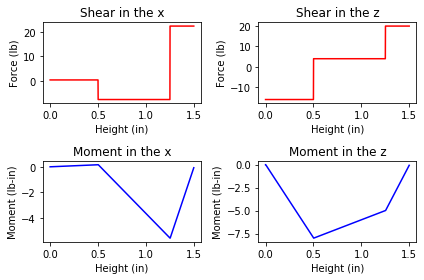

In [3]:
# Import relevant modules
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Define variables for plotting
Nx = 1000
dy = h_end/Nx
y = [dy*step for step in range(Nx)]
vx = [0]*Nx
vz = [0]*Nx

# Fill arrays for shear diagrams
for i in range(Nx):
    vx[i] = sum([vec.x for vec in [FA,FB,F_gear,F_cam] if vec.y_0 <= dy*i])

for i in range(Nx):
    vz[i] = sum([vec.z for vec in [FA,FB,F_gear,F_cam] if vec.y_0 <= dy*i])

# Numerically integrate
Mx = [np.trapz(vx[:i],y[:i]) for i in range(Nx)]
Mz = [np.trapz(vz[:i],y[:i]) for i in range(Nx)]

# Plot diagrams
fig,axs = plt.subplots(2,2)

axs[0][0].plot(y,vx,'r')
axs[0][0].set_title("Shear in the x")
axs[0][0].set_xlabel("Height (in)")
axs[0][0].set_ylabel("Force (lb)")

axs[1][0].plot(y,Mx,'b')
axs[1][0].set_title("Moment in the x")
axs[1][0].set_xlabel("Height (in)")
axs[1][0].set_ylabel("Moment (lb-in)")

axs[0][1].plot(y,vz,'r')
axs[0][1].set_title("Shear in the z")
axs[0][1].set_xlabel("Height (in)")
axs[0][1].set_ylabel("Force (lb)")

axs[1][1].plot(y,Mz,'b')
axs[1][1].set_title("Moment in the z")
axs[1][1].set_xlabel("Height (in)")
axs[1][1].set_ylabel("Moment (lb-in)")

fig.tight_layout()

$\textbf{Stress Analysis:}$

<p>Examining the shear-moment diagrams, it appears that the most stress will occur where the cam is attached, so that is the point we will focus in on, using the equations:

$$\sigma_{yy} = \dfrac{(-M_z + M_x)r}{I}$$
$$\sigma_{xz} = \dfrac{V_zQ}{2Ir}$$
$$\sigma_{xy} = \dfrac{V_xQ}{2Ir}$$

and solving for the principal strains to calculate the maximum shear stress as:

$$\tau_{max} = \dfrac{\left| \sigma_1 - \sigma_3 \right|}{2}$$

where $\sigma_1$ and $\sigma_3$ are the maximum and minimum principal stresses, respectively.</p>

<p>From there, we can use a Tresca failure criterion and evaluate for the safety factor, N, as:

$$N = \dfrac{S_y}{\tau_{max}}$$

</p>

<p>The necessary diameter of the shaft will be determined by brute-force iteration.</p>

In [8]:
# Determine point of interest and shear and moments acting at that point
indx_min = Mx.index(min(Mx))
Mx_interest = min(Mx)
Mz_interest = Mz[indx_min]
Vx_interest = vx[indx_min]
Vz_interest = vz[indx_min]

# Define first and second moments of area equations
Q_eq = lambda i: 1/2 * np.pi * r**3
I_eq = lambda r: 1/4 * np.pi * r**4

# Iterate
step = 1.0e-5
r = step
for n in range(int(1.0e6)):
    # Determine
    I=I_eq(r)
    Q=Q_eq(indx_min)
    
    # Determine maximum shear stress
    sig_yy = (-Mx_interest-Mz_interest)*r/I
    sig_yz = Vz_interest*Q/(I*2*r)
    sig_xy = Vx_interest*Q/(I*2*r)
    sig = [[0,sig_xy,0],
           [sig_xy,sig_yy,sig_yz],
           [0,sig_yz,0]]
    prin_str = list(np.linalg.eigvals(sig))
    prin_str.sort(reverse=True)
    sig1,sig2,sig3 = prin_str
    tau_max = abs(sig1-sig3)/2
    
    # Determine safety factor
    N_test = Sy/tau_max
    
    # Decide if safety factor is acceptable
    if N_test >= N:
        break
    else:
        r += step
        
# Print results
print("Necessary Diameter: {}\"".format(round(2*r,4)))

Necessary Diameter: 0.126"


$\textbf{Conclusion:}$

<p>By solving for the reaction forces, plotting shear-moment diagrams and determing a maximum shear stress, it was possible to determine a reasonable diameter for the shaft as:
$$D_{shaft}=0.1260\text{  in}$$
</p>